<a href="https://colab.research.google.com/github/cerezamo/NLP_brouillon/blob/master/Partie_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Are female, politicians like any other ? 

## Part I : Corpus analysis

### Downloading packages

In [1]:
!python -m spacy download fr_core_news_md
import nltk
nltk.download('punkt')


    Error: Couldn't link model to 'fr_core_news_md'
    Creating a symlink in spacy/data failed. Make sure you have the required
    permissions and try re-running the command as admin, or use a
    virtualenv. You can still import the model as a module and call its
    load() method, or create the symlink manually.

    C:\Users\morga\Anaconda3\lib\site-packages\fr_core_news_md -->
    C:\Users\morga\Anaconda3\lib\site-packages\spacy\data\fr_core_news_md


    Creating a shortcut link for 'en' didn't work (maybe you don't have
    admin permissions?), but you can still load the model via its full
    package name: nlp = spacy.load('{name}')
    Download successful but linking failed



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\morga\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
import spacy
from funct import *
import matplotlib.pyplot as plt
import numpy as np
from functools import reduce
from operator import add
from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop
from spacy.tokenizer import Tokenizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import RegexpTokenizer
from os import path
from PIL import Image
import funct
sent_detector = nltk.data.load('tokenizers/punkt/french.pickle')
nlp = spacy.load('fr_core_news_md') 
import multiprocessing as mp
from collections import Counter
#from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set_palette("husl")

We import our corpus in the notebook. This corpus has been scrapped from : https://www.vie-publique.fr/discours.

In [4]:
df = pd.read_csv('medium_df_deseq.csv')
df.head()

,Unnamed: 0,Id,Titre,Type,Theme,Prenom,Nom,Fonction,Date,Tags,Texte,Lien,PRENOM,preusuel,sexe
0,10504,144565,"Déclaration de M. Jacques Chirac, Président de...",déclaration,International,Jacques,Chirac,NaN,1998-10-03T12:00:00Z,"Défense,Politique de la défense","Messieurs,Je suis heureux de vous saluer. Quan...",https://www.vie-publique.fr/discours/144565-de...,JACQUES,JACQUES,1
1,3304,196091,"Déclaration de M. Laurent Fabius, ministre des...",déclaration,Société,Laurent,Fabius,NaN,2015-08-26T12:00:00Z,"Environnement,Climat",Tout ce que nous avons entendu au cours de cet...,https://www.vie-publique.fr/discours/196091-de...,LAURENT,LAURENT,1
2,8816,128510,"Déclaration de M. François Hollande, premier s...",déclaration,Institutions,François,Hollande,NaN,2002-03-14T12:00:00Z,"Citoyenneté - Elections,Personnalité politique","Cher(e)s Ami(e)s, Cher(e)s Camarades, C'est av...",https://www.vie-publique.fr/discours/128510-de...,FRANÇOIS,FRANÇOIS,1
3,19491,140697,"Déclaration de M. Alain Lambert, ministre délé...",déclaration,International,Alain,Lambert,NaN,2003-06-11T12:00:00Z,"Relations internationales,Frontière","Mesdames,messieurs, C'est avec grand plaisir q...",https://www.vie-publique.fr/discours/140697-de...,ALAIN,ALAIN,1
4,6289,195589,"Déclaration de M. François Hollande, Président...",déclaration,International,François,Hollande,NaN,2015-07-03T12:00:00Z,"Relations internationales,Relations bilatérale...","Mesdames, Messieurs, bonsoir - j'allais dire b...",https://www.vie-publique.fr/discours/195589-de...,FRANÇOIS,FRANÇOIS,1


### Some basic external statistics

We clean the encoding of the text as a first treatment. 

In [5]:
df.Texte = df.Texte.apply(lambda x : x.replace('\xa0','').replace('\x85','').replace('\x96','').replace('\x92',"'").replace('\x80',''))
df.Texte = df.Texte.apply(remove_source)

In [6]:
print('On average, text length is {}'.format(round(df.Texte.apply(len).mean())))

On average, text length is 11571


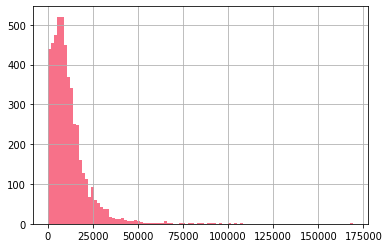

In [7]:
%matplotlib inline
df.Texte.apply(len).hist(bins=100)
plt.show()

In [8]:
# POru l'instant drop quand trop long 
#df_small = df[df.Texte.apply(len)<5000]

In [9]:
#len(df_small)

In [10]:
#df=df_small.reset_index()

#### Speakers gender proportions

In [11]:
print('The corpus gathers {} political speeches' .format(len(df)))
print('There are {} male speakers and {} female speakers'.format(df.sexe.map(str).value_counts()[0],df.sexe.map(str).value_counts()[1]))

The corpus gathers 5000 political speeches
There are 3750 male speakers and 1250 female speakers


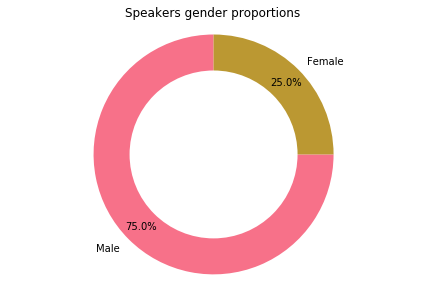

In [12]:
labels = ['Male','Female']
#colors = ['#ffcc99','#ff9999']
sizes = [ len(df[df.sexe ==1]),len(df[df.sexe ==2])]
fig, ax1 = plt.subplots()
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85)
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
ax1.axis('equal')  
plt.tight_layout()
plt.title("Speakers gender proportions")
plt.show()

Without surprise we have an unbalanced corpus with men being much more represented than women.

#### Speakers gender through time 

One of the very nice feature of our corpus is that we have access to almot all government speeches and interview from 1990. Let's see how the proportion of women and men in the corpus changed through years. 

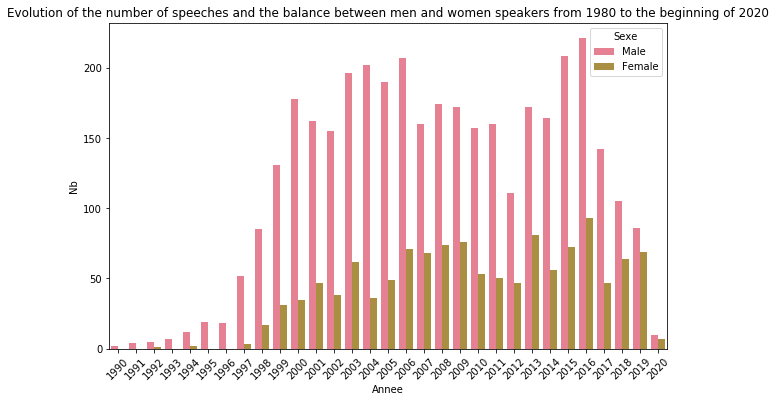

In [13]:
df['Annee']= df.Date.map(str).apply(lambda x:x[:4])
lst=[]
for an in df.Annee.unique():
    for s in df.sexe.unique():
        if s == 1:
            sexe= 'Male'
        else:
            sexe='Female'
        lst+=[(an,len(df[(df.Annee == an) & (df.sexe == s)]),sexe)]
data = pd.DataFrame(lst,columns=['Annee','Nb','Sexe'])
data=data[data['Annee']>='1990']
plt.figure(figsize=(10,6))
sns.barplot(data = data,
            x='Annee',
            y='Nb',
           hue='Sexe')
plt.xticks(rotation = 45)
plt.title("Evolution of the number of speeches and the balance between men and women speakers from 1980 to the beginning of 2020")
plt.show()

We definitely see an increase in the absolute number of female speakers. However the gap is still important. 
In 2019 we see that eventually the number of male and female speakers are really close. 

####  Speaker's gender and speeches general theme

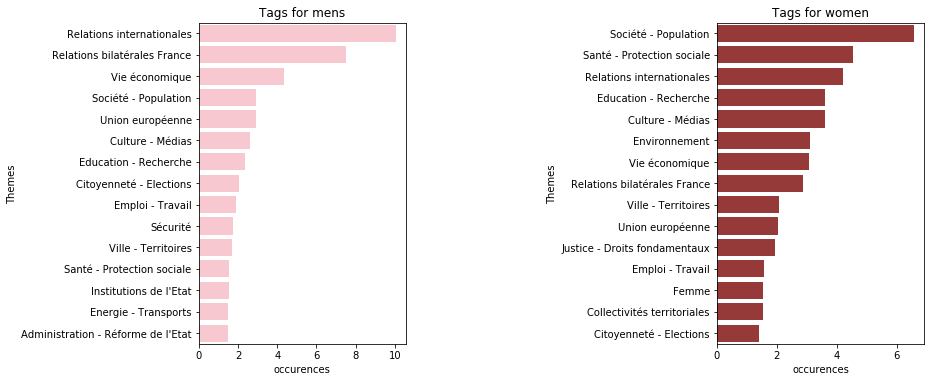

In [14]:
df.Tags.fillna('',inplace=True)
arr =df[df.sexe == 2].Tags.apply(lambda x: str(x).split(',')).array
arr = reduce(add,arr)
c = Counter(arr)
d_f = pd.DataFrame(c, index=['occurrences']).transpose().reset_index()
d_f.columns=['Themes', 'occurences']
d_f.occurences = d_f.occurences.apply(lambda x:(x/d_f.occurences.sum())*100)
d_f['sexe'] = 'Female'
arr =df[df.sexe == 1].Tags.apply(lambda x: str(x).split(',')).array
arr = reduce(add,arr)
c = Counter(arr)
d_m = pd.DataFrame(c, index=['occurrences']).transpose().reset_index()
d_m.columns=['Themes', 'occurences']
d_m.occurences = d_m.occurences.apply(lambda x:(x/d_m.occurences.sum())*100)
d_m['sexe'] = 'Male'
d = pd.concat([d_f,d_m])
plt.figure(figsize=(13,13))
plt.subplot(221)
sns.barplot(data = d[(d.occurences >= 0.5) & (d.Themes.apply(len) >0) & (d.sexe == 'Male')].sort_values('occurences',ascending=False).head(15),
            y='Themes',
            x='occurences',
           color='pink')
plt.title("Tags for mens")
plt.subplot(222)
sns.barplot(data = d[(d.occurences >= 0.6) & (d.Themes.apply(len) >0) & (d.sexe == 'Female')].sort_values('occurences',ascending=False).head(15),
            y='Themes',
            x='occurences',
           color = 'brown')
plt.title("Tags for women")
plt.subplots_adjust(wspace = 1.5)

Men and women are not talking about the same subjects. If women are more likely to speak about Society and Health, men are more likely to speak about international relations and economics. 

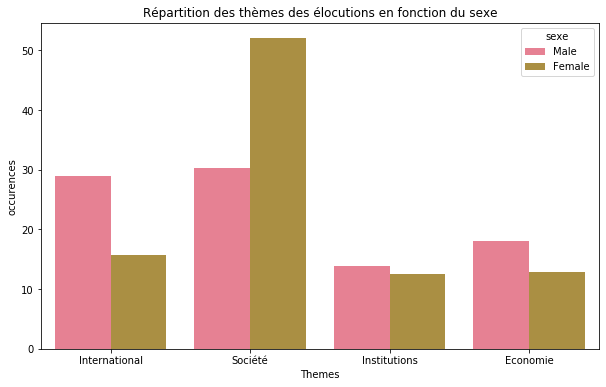

In [15]:
df.Theme.fillna('',inplace=True)
arr =df[df.sexe == 1].Theme.apply(lambda x: str(x).split(',')).array
arr = reduce(add,arr)
c = Counter(arr)
d_m = pd.DataFrame(c, index=['occurrences']).transpose().reset_index()
d_m.columns=['Themes', 'occurences']
d_m.occurences = d_m.occurences.apply(lambda x:(x/d_m.occurences.sum())*100)
d_m['sexe'] = 'Male'
arr =df[df.sexe == 2].Theme.apply(lambda x: str(x).split(',')).array
arr = reduce(add,arr)
c = Counter(arr)
d_f = pd.DataFrame(c, index=['occurrences']).transpose().reset_index()
d_f.columns=['Themes', 'occurences']
d_f.occurences = d_f.occurences.apply(lambda x:(x/d_f.occurences.sum())*100)
d_f['sexe'] = 'Female'
d = pd.concat([d_m,d_f])
plt.figure(figsize=(10,6))
sns.barplot(data = d[d.Themes != ''],hue = 'sexe',x='Themes',y='occurences')
plt.title('Répartition des thèmes des élocutions en fonction du sexe')
plt.xticks(rotation=0)
plt.show()

We represent the same chart but with a lower level of granularity in themes. The same conclustion can be drawn. 

After this brief introduction we will dive into our texts. The next section focuses on cleaning and preprocessing our texts. We will try to construct some quantitative metrics that could be , in our opinion, explanatory features to differenciate female and male speakers. 


### Word-level preprocessing

Let's try different tokenizers ! 

In [16]:
tokenizer = Tokenizer(nlp.vocab)
toknizer = RegexpTokenizer(r'''\w'|\w+|[^\w\s]''')

In [17]:
print(len([w for w in tokenizer(df.Texte[0])]))

1702


In [18]:
([w for w in tokenizer(df.Texte[0])])[0:10]

[Messieurs,Je, suis, heureux, de, vous, saluer., Quand, je, dis, que]

In [19]:
print(len(word_tokenize(df.Texte[0], language='french')))

1932


In [20]:
word_tokenize(df.Texte[0], language='french')[0:10]

['Messieurs',
 ',',
 'Je',
 'suis',
 'heureux',
 'de',
 'vous',
 'saluer',
 '.',
 'Quand']

In [21]:
print(len(toknizer.tokenize(df.Texte[0])))

2135


In [22]:
toknizer.tokenize(df.Texte[0])[0:10]

['Messieurs',
 ',',
 'Je',
 'suis',
 'heureux',
 'de',
 'vous',
 'saluer',
 '.',
 'Quand']

In [23]:
toknizer.tokenize(df.Texte[0])[0:10]

['Messieurs',
 ',',
 'Je',
 'suis',
 'heureux',
 'de',
 'vous',
 'saluer',
 '.',
 'Quand']

The NLTK tokenizer tokenizes punctuation whereas the spacy one does not. We decide to switch to the NLTK tokenizer.

In [24]:
print('Length of spacy stopwords list is {} and length of NLTK stopwords list is {} '.format(len(list(fr_stop)),len(stopwords.words('french'))))

Length of spacy stopwords list is 602 and length of NLTK stopwords list is 157 


As the NLTK sent detector is far from being optimal we tried to detect sentences with the 'sent_detector_mano' function which seems to work much better on our corpus.

J'ai ajouté un cleaner pour les Noms/Prénoms des politiques basés sur les noms/prénoms des personnalités politiques présentes dans la base. 

J'ajoute également un cleaner pour Mr, Mme , M , Madame et Monsieur, Mesdames, Messieurs.

Voir si président et ministre sont à ajouter.

In [25]:
df['NbToken'] = df.Texte.apply(lambda x : len(word_tokenize(x,language='french')))
df['Token'] = df.Texte.apply(lambda x : word_tokenize(x,language='french'))

In [26]:
lst_nom = [nom for nom in set(df.Nom+ ' ' +df.Prenom) if nom not in 'ministère'] + [nom for nom in set(df.Prenom+ ' ' +df.Nom) if nom not in 'ministère']+ [nom for nom in set(df.Prenom) if nom != 'ministère'] + [nom for nom in set(df.Nom) if nom != 'ministère']
cleanFast = lst_nom + ['Mr','M','Mme','Madame','Monsieur','monsieur','madame','mme','mr','mesdames','messieurs']

In [27]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  8


add_features()
Sert pour la parallélisation
Input : DataFrame
Output : DataFrame with new columns created

para_df()
Parralelisation
Input : 
      df : DataFrame
      func : function to return data
      n_cores : number of cores
Output : 
      df with new columns
  """

In [28]:
def add_features(df):
    from multiprocessing import Pool
    nlp = spacy.load('fr_core_news_md') 
    df['NbCleanToken'] = df.Texte.apply(lambda x : len(cleanToken(x)))
    df['NbSyllables'] = df.Texte.apply(NbSyllables)
    df['NbMot'] = df.Texte.apply(extraire_nb_mot)
    df['Phrases'] = df.Texte.apply(sent_detector_mano)
    df['NbPhrases'] = df.Texte.apply(lambda x:len(sent_detector_mano(x)))
    df['CleanToken'] = df.Texte.apply(cleanToken)
    df.CleanToken = df.apply(lambda row : FastCleaner(row.CleanToken,cleanFast),axis=1)
    df['NbCleanToken']=df.CleanToken.apply(len)
    df['NbPonct'] = df.Texte.apply(count_punct)
    df['NbSw'] = df.Token.apply(count_stopwords)
    df['Hapaxlegomena']=df.CleanToken.apply(Hapaxlegomena)
    df['Hapaxdislegomena']= df.CleanToken.apply(Hapaxdislegomena)
    df['UniqueWordTx']= df.CleanToken.apply(lambda x:len(set(x))/len(x))
    #df['RateCleanRaw'] = df.NbCleanToken/df.NbToken
    df['NbNom'],df['NbDet'],df['NbPunct'],df['NbAdj'],df['NbAdp'],df['NbPron'],df['NbVerb'],df['NbCconj'],df['NbNum'],df['NbPropn'],df['NbAdv'],df['NbSCONJ'],df['NbAUX'],df['NbIntj']=zip(*df.Texte.apply(extractPos))
    df['NbArt']= df.Texte.apply(nbArt)
    df['F_mesure'] = df.apply(lambda row: f_mesure(row.NbToken,row.NbNom,row.NbAdj,row.NbAdp,row.NbArt,row.NbPron,row.NbVerb,row.NbAdv,row.NbIntj),axis=1)
    df['PronJe']=df.apply(lambda row : Pron_Type(row.Texte,nlp),axis=1)
    df['PronNous']=df.apply(lambda row : Pron_Type_Plur(row.Texte,nlp),axis=1)
    df['NbPres'],df['NbPast'],df['NbFut'],df['NbImp']  = zip(*df.apply(lambda row : Verb_Tens(row.Texte,nlp),axis=1))
    df['NbQuest']= df.apply(lambda row : Quest(row.Texte,nlp),axis=1)
    df['NbExcl']= df.apply(lambda row  : Excl(row.Texte,nlp),axis=1)
    return df
def para_df(df,func,n_cores = mp.cpu_count()):
    from multiprocessing import Pool
    df_split = np.array_split(df,n_cores)
    pool = Pool(n_cores)
    df = pd.concat(pool.map(func,df_split))
    pool.close()
    pool.join()
    return df

In [29]:
df['NbNom'],df['NbDet'],df['NbPunct'],df['NbAdj'],df['NbAdp'],df['NbPron'],df['NbVerb'],df['NbCconj'],df['NbNum'],df['NbPropn'],df['NbAdv'],df['NbSCONJ'],df['NbAUX'],df['NbIntj']=zip(*df.Texte.apply(extractPos))
 

In [30]:
df['NbMot'] = df.Texte.apply(extraire_nb_mot)

In [31]:
df['PronJe']=df.apply(lambda row : Pron_Type(row.Texte,nlp),axis=1)
df['PronNous']=df.apply(lambda row : Pron_Type_Plur(row.Texte,nlp),axis=1)
#Mettre tout en meme temps 

In [ ]:
df['NbPres'],df['NbPast'],df['NbFut'],df['NbImp']  = zip(*df.apply(lambda row : Verb_Tens(row.Texte,nlp),axis=1))
df['NbQuest']= df.apply(lambda row : Quest(row.Texte,nlp),axis=1)
df['NbExcl']= df.apply(lambda row  : Excl(row.Texte,nlp),axis=1)

In [ ]:
df['NbArt']= df.Texte.apply(nbArt)
df['F_mesure'] = df.apply(lambda row: f_mesure(row.NbToken,row.NbNom,row.NbAdj,row.NbAdp,row.NbArt,row.NbPron,row.NbVerb,row.NbAdv,row.NbIntj),axis=1)

In [ ]:
df['CleanToken'] = df.Texte.apply(cleanToken)
df['Hapaxlegomena']=df.CleanToken.apply(Hapaxlegomena)
df['Hapaxdislegomena']= df.CleanToken.apply(Hapaxdislegomena)
df['UniqueWordTx']= df.CleanToken.apply(lambda x:len(set(x))/len(x))

In [ ]:
plt.figure(figsize=(14,14))
plt.subplot(2, 2, 1)
sns.distplot(df[df.sexe == 2]['Hapaxlegomena'])
sns.distplot(df[df.sexe == 1]['Hapaxlegomena'])
plt.subplot(2, 2, 2)
sns.distplot(df[df.sexe == 2]['Hapaxdislegomena'])
sns.distplot(df[df.sexe == 1]['Hapaxdislegomena'])
plt.subplot(2, 2, 3)
sns.distplot(df[df.sexe == 2]['UniqueWordTx'])
sns.distplot(df[df.sexe == 1]['UniqueWordTx'])
plt.subplot(2, 2, 4)
sns.distplot(df[df.sexe == 2]['F_mesure'])
sns.distplot(df[df.sexe == 1]['F_mesure'])
plt.show()

In [ ]:
#df = para_df(df,add_features)

In [ ]:
df[['NbNom_prec']]=df[['NbNom']].div(df.NbMot,axis=0)

df[['NbDet_prec']]=df[['NbDet']].div(df.NbMot,axis=0)

df[['NbAdj_prec']]=df[['NbAdj']].div(df.NbMot,axis=0)

df[['NbPron_prec','NbVerb_perc','NbAUX_perc']]=df[['NbPron','NbVerb','NbAUX']].div(df.NbMot,axis=0)

In [ ]:
plt.figure(figsize=(14,14))
plt.subplot(2, 2, 1)
sns.distplot(df[df.sexe == 2]['NbNom_prec'])
sns.distplot(df[df.sexe == 1]['NbNom_prec'])
plt.subplot(2, 2, 2)
sns.distplot(df[df.sexe == 2]['NbAdj_prec'])
sns.distplot(df[df.sexe == 1]['NbAdj_prec'])
plt.subplot(2, 2, 3)
sns.distplot(df[df.sexe == 2]['NbPron_prec'])
sns.distplot(df[df.sexe == 1]['NbPron_prec'])
plt.subplot(2, 2, 4)
sns.distplot(df[df.sexe == 2]['NbVerb_perc'])
sns.distplot(df[df.sexe == 1]['NbVerb_perc'])
plt.show()

Au dela du nombre ce qui est interessant d'observer c'est quel type de pronom, nom, verbes les hommes et les femmes utilisent. 

In [ ]:
lst=[ 'NbSyllables','NbPhrases','NbMot','NbToken','NbCleanToken', 'NbPonct', 'NbSw','Hapaxlegomena', 'Hapaxdislegomena', 
       'UniqueWordTx', 'RateCleanRaw','NbNom', 'NbDet', 'NbPunct', 'NbAdj', 'NbAdp', 'NbPron', 'NbVerb',
        'NbCconj', 'NbNum', 'NbPropn', 'NbAdv', 'NbSCONJ', 'NbAUX', 'NbIntj','NbArt', 'F_mesure'
        ]
lst = lst + ['NbNom_prec','NbDet_prec','NbAdj_prec',
    'NbPron_prec','NbVerb_perc','NbAUX_perc']
df[['PronJe_perc','PronNous_perc']]=df[['PronJe','PronNous']].div(df.NbMot,axis=0)
lst = lst + ['PronJe_perc','PronNous_perc']
plt.figure(figsize=(14,14))
plt.subplot(2, 2, 1)
sns.distplot(df[df.sexe == 2]['PronJe_perc'])
sns.distplot(df[df.sexe == 1]['PronJe_perc'])
plt.subplot(2, 2, 2)
sns.distplot(df[df.sexe == 2]['PronNous_perc'] )
sns.distplot(df[df.sexe == 1]['PronNous_perc'])
plt.show()

De plus grosses différences sur le j en terme de distr mais une queue de distribution plus importante pour les nous en bas ( à voir finalement si je divise par le nombre de pronom pas vraiment. 

In [ ]:
df[['NbQuest_perc','NbExcl_perc']]=df[['NbQuest','NbExcl']].div(df.NbToken,axis=0)
plt.figure(figsize=(14,14))
plt.subplot(2, 2, 1)
sns.distplot(df[df.sexe == 2]['NbQuest_perc'])
sns.distplot(df[df.sexe == 1]['NbQuest_perc'])
plt.subplot(2, 2, 2)
sns.distplot(df[df.sexe == 2]['NbExcl_perc'])
sns.distplot(df[df.sexe == 1]['NbExcl_perc'])
plt.show()

### Sentiment extraction using FEEL (French Expanded Emotion Lexicon)

http://advanse.lirmm.fr/feel.php

In [ ]:
feel = pd.read_csv('FEEL.csv',sep=';')
feel.set_index('id',inplace=True)
feel.sample(10)

In [ ]:
def extraction_emotion(tokens):
    """
        Permet d'extraire le nombre de mot classé dans 6 émotions différentes.
        Input : Tokens
        Output : (Joie,peur,tristesse,colère,surprise,dégoût) en fréquence
    """
    joie = [w for w in tokens if w in feel[feel.joy == 1].word.values]
    peur = [w for w in tokens if w in feel[feel.fear == 1].word.values]
    tristesse = [w for w in tokens if w in feel[feel.sadness == 1].word.values]
    colere = [w for w in tokens if w in feel[feel.anger == 1].word.values]
    surprise = [w for w in tokens if w in feel[feel.surprise == 1].word.values]
    degout = [w for w in tokens if w in feel[feel.disgust == 1].word.values]
    return [len(joie)/len(tokens),len(peur)/len(tokens),len(tristesse)/len(tokens),len(colere)/len(tokens),len(surprise)/len(tokens),len(degout)/len(tokens)]

In [ ]:
def check_polarity(tokens):
    """
        Analyse de sentiment de chaque mots
        Input : Tokens
        Output :  (%positive,%negative,%non trouvé) en fréquen
    """
    pos = feel[feel.polarity == 'positive'].word.values
    neg = feel[feel.polarity == 'negative'].word.values
    nb_pos = [word for word in tokens if word in pos]
    nb_neg = [word for word in tokens if word in neg]
    return [len(nb_pos)/len(tokens),len(nb_neg)/len(tokens),1 - (len(nb_pos) + len(nb_neg))/len(tokens)]

In [ ]:
extraction_emotion(cleanTokenLemme(df.Texte[0],cleanFast))

In [ ]:
check_polarity(cleanTokenLemme(df.Texte[0],cleanFast))

In [ ]:
def add_features2(df):
    """
    Sert pour la parallélisation
    Input : DataFrame
    Output : DataFrame avec les nouvelles colonnes crée
  """
    df['CleanTokensLemme'] = df.apply(lambda row : cleanTokenLemme(row.Texte,cleanFast),axis=1)
    df['PolPos'],df['PolNeg'],df['PolUnk'] = zip(*df.CleanTokensLemme.apply(check_polarity))
    df['FreqJoie'],df['FreqPeur'],df['FreqSad'],df['FreqColere'],df['FreqSurprise'],df['FreqDegout'] = zip(*df.CleanTokensLemme.apply(extraction_emotion))
    return df

In [ ]:
df['CleanTokensLemme'] = df.apply(lambda row : cleanTokenLemme(row.Texte,cleanFast),axis=1)
df['PolPos'],df['PolNeg'],df['PolUnk'] = zip(*df.CleanTokensLemme.apply(check_polarity))
df['FreqJoie'],df['FreqPeur'],df['FreqSad'],df['FreqColere'],df['FreqSurprise'],df['FreqDegout'] = zip(*df.CleanTokensLemme.apply(extraction_emotion))


In [ ]:
#df = para_df(df,add_features2)

In [ ]:
plt.figure(figsize=(14,14))
plt.subplot(2, 2, 1)
sns.distplot(df[df.sexe == 2]['FreqJoie'])
sns.distplot(df[df.sexe == 1]['FreqJoie'])
plt.subplot(2, 2, 2)
sns.distplot(df[df.sexe == 2]['FreqPeur'])
sns.distplot(df[df.sexe == 1]['FreqPeur'])
plt.subplot(2, 2, 3)
sns.distplot(df[df.sexe == 2]['FreqSad'])
sns.distplot(df[df.sexe == 1]['FreqSad'])
plt.subplot(2, 2, 4)
sns.distplot(df[df.sexe == 2]['FreqColere'])
sns.distplot(df[df.sexe == 1]['FreqColere'])
plt.show()


## Passons désormais au n-grams

Utilisation des tokens cleané et lemmatizer pour obtenir le n-gram
Il est possible de voir que le bi-gram ne semble par très pertinant au regard des mots qui ressortent et qui semble ne pas trop varier en fonction du sexe. 

Mo : Faudrait peut être même faire ca avant ? 

In [ ]:
df.Texte = df.Texte.apply(lambda x : x.replace('\xa0','').replace('\x85','').replace('\x96','').replace('\x92',"'").replace('\x80','').replace('\xc3',''))
df.Texte = df.Texte.apply(remove_source)

In [ ]:
from tqdm import tqdm
def tokenize_sent(corpus):
    tokenizer = Tokenizer(nlp.vocab)
    tokenized_sentences = []
    for sample in tqdm(corpus):
        for sentence in sent_detector.tokenize(sample):
            tokens = toknizer.tokenize(sentence)
            tokens = list(map(lambda x: x.lower(), tokens))
            tokenized_sentences.append(tokens)
    return tokenized_sentences

In [ ]:
#toknizer.tokenize(sent_detector.tokenize(df.Texte[0])[0])

In [ ]:
cleaned_corp = tokenize_sent(df.Texte.array)

In [ ]:
from gensim.models.phrases import Phrases, Phraser

def show_phrases(tokenized_sentences, threshold=100, shown=15):
    phrases = Phrases(tokenized_sentences, threshold=threshold)
    i = 0
    for phrase, score in phrases.export_phrases(tokenized_sentences):
        if i>shown:
            break
        else:
            print("Expression : {0}, score = {1}".format(phrase, score))
    i=i+1

In [ ]:
show_phrases(cleaned_corp)

In [ ]:
def clean_corpus(corpus, threshold=100):
    tokenized_sentences = tokenize_sent(corpus)
    phrases = Phrases(tokenized_sentences, threshold=threshold)
    phraser = Phraser(phrases)
    
    clean_corpus = []
    for sample in corpus:
        clean_corpus.append(phraser[sample])
    return clean_corpus

In [ ]:
clean_corpus_gensim =clean_corpus(df.Token.array)

In [ ]:
df['gensim']=pd.DataFrame([clean_corpus_gensim]).transpose()

In [ ]:
# Metre le wordcloud après gensim 

In [ ]:
import numpy as np
woman = np.array(Image.open("femme2.png"))
wc = WordCloud(background_color="white", max_words=100, mask=woman,
               stopwords=list(fr_stop)+["c'est","d'un","d'une","qu'il","n'est","j'ai","qu'elle"], contour_width=0.5, contour_color='black')
arr = reduce(add,df[df.sexe == 2].CleanToken.array)
corpus_f = ' '.join(arr)
wc.generate(corpus_f)
man = np.array(Image.open("homme.png"))
wc2 = WordCloud(background_color="white", max_words=100, mask=man,
               stopwords=list(fr_stop)+["c'est","d'un","d'une","qu'il","n'est","j'ai","qu'elle"], contour_width=1, contour_color='black')
arr = reduce(add,df[df.sexe == 1].CleanToken.array)
corpus_m = ' '.join(arr)
wc2.generate(corpus_m)

plt.figure(figsize=[10,10])
plt.subplot(121)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.subplot(122)
plt.imshow(wc2, interpolation='bilinear')
plt.axis("off")

plt.show()

#Je veux pas faire la féministe mais ces dessins ? hahaha 
# Le truc c'est qu'il faut une silhouette en noir et blanc sinon c'est relou à corriger ! 

In [ ]:
from nltk import ngrams
arr = df[df.sexe == 1].CleanTokensLemme.array
arr = reduce(add,arr)
arr = ' '.join(arr)
arr = arr.split()
bigram_count = Counter(ngrams(arr, 2))

In [ ]:
bigram_count.most_common(50)

In [ ]:
arr = df[df.sexe == 2].CleanTokensLemme.array
arr = reduce(add,arr)
arr = ' '.join(arr)
arr = arr.split()
bigram_count = Counter(ngrams(arr, 2))

In [ ]:
bigram_count.most_common(50)

Passons aux tri-grams, on remarque déjà la présence toujours de personnes politiques (certains textes sont topés discours ou déclarations mais sont en réalité des interviews). Ensuite, on a énormément de (madame, monsieur + un titre), on supprime?

Mo : Pour l'analyse des features comme on le fait la oui on va enlever. Pour les N-grams il faudrait que trier avant et ne prend que les types de mots qui ne sont pas de sprénoms.

Mel : Update du 17/03, noramlement c'est bon

In [ ]:
arr = df[df.sexe == 1].CleanTokensLemme.array
arr = reduce(add,arr)
arr = ' '.join(arr)
arr = arr.split()
trigram_count = Counter(ngrams(arr, 3))

In [ ]:
trigram_count.most_common(50)

In [ ]:
arr = df[df.sexe == 2].CleanTokensLemme.array
arr = reduce(add,arr)
arr = ' '.join(arr)
arr = arr.split()
trigram_count = Counter(ngrams(arr, 3))

In [ ]:
trigram_count.most_common(50)

In [ ]:
import numpy as np
woman = np.array(Image.open("femme2.png"))
wc = WordCloud(background_color="white", max_words=100, mask=woman,
               stopwords=list(fr_stop)+["c'est","d'un","d'une","qu'il","n'est","j'ai","qu'elle"], contour_width=0.5, contour_color='black')
arr = reduce(add,df[df.sexe == 2].CleanToken.array)
corpus_f = ' '.join(arr)
wc.generate(corpus_f)
man = np.array(Image.open("homme.png"))
wc2 = WordCloud(background_color="white", max_words=100, mask=man,
               stopwords=list(fr_stop)+["c'est","d'un","d'une","qu'il","n'est","j'ai","qu'elle"], contour_width=1, contour_color='black')
arr = reduce(add,df[df.sexe == 1].CleanToken.array)
corpus_m = ' '.join(arr)
wc2.generate(corpus_m)

plt.figure(figsize=[10,10])
plt.subplot(121)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.subplot(122)
plt.imshow(wc2, interpolation='bilinear')
plt.axis("off")

plt.show()

#Je veux pas faire la féministe mais ces dessins ? hahaha 
# Le truc c'est qu'il faut une silhouette en noir et blanc sinon c'est relou à corriger ! 

In [ ]:
df.to_csv('minimal_df_var.csv')

References 

https://bib.irb.hr/datoteka/861053.Gender_differences_in_the_personal_pronouns_usage_of_the_corpus_of_congressional_speeches.pdf

https://www.researchgate.net/publication/253291274_Gender_Differences_in_Language_Use_An_Analysis_of_14000_Text_Samples/link/571e3c1b08aeaced7889ddce/download